In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import imageio

In [2]:
pip install imageio[pyav]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 7.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In the variables **im1** and **im2**, we will load images **A** and **B**, which we will be working on. They must be in the same directory as this file.

/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_32284/264005298.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imageio.imread("img1.jpg")# ,N)
/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_32284/264005298.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im2 = imageio.imread("img2.jpg")# ,N)


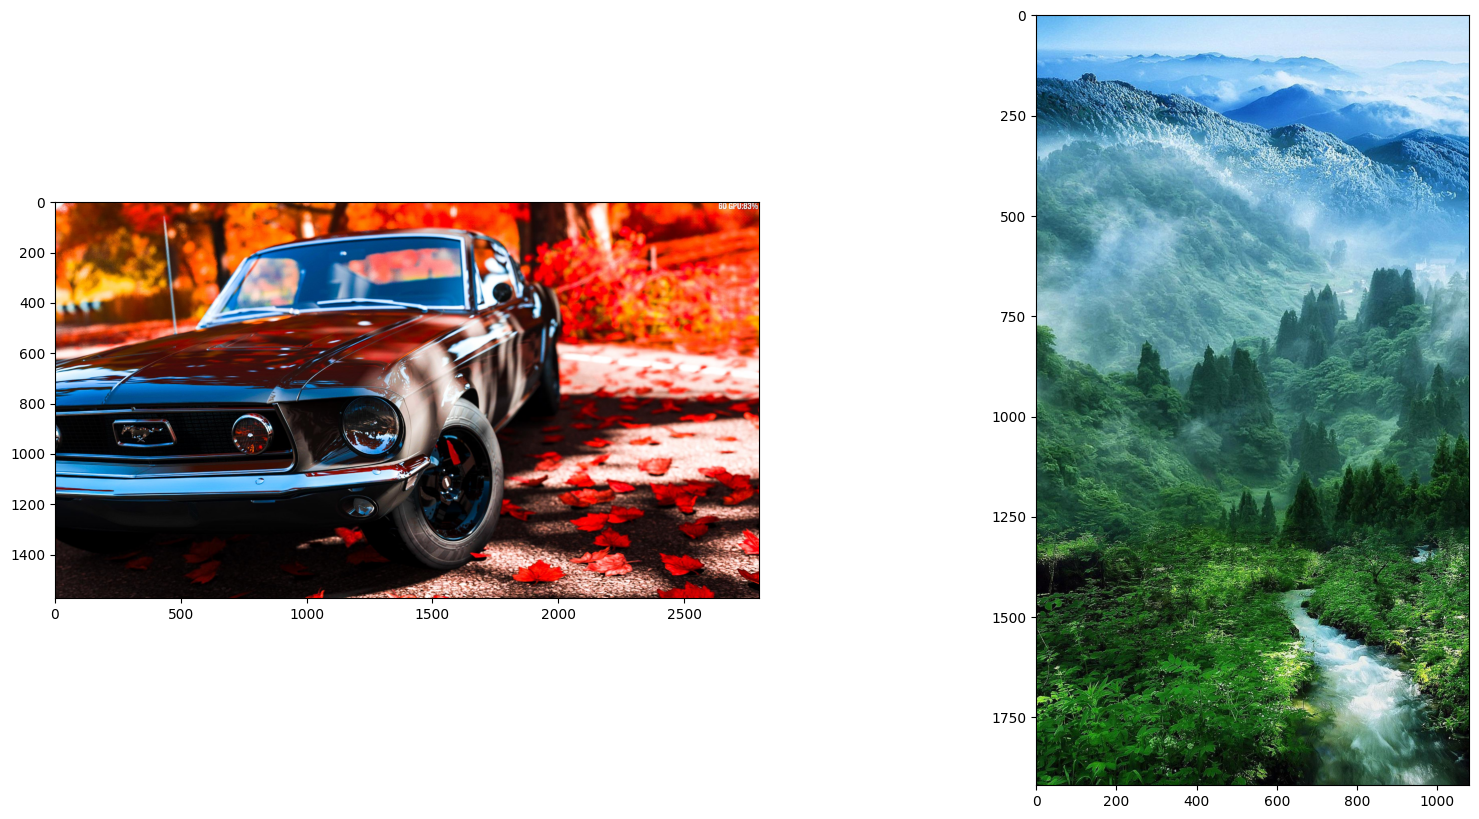

In [3]:
im1 = imageio.imread("img1.jpg")# ,N)
im2 = imageio.imread("img2.jpg")# ,N)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)

#convolution par un noyau gaussien en dimension 3
def K3d(a, kernel):
    res = np.zeros([64, 64, 64])
    for i in range(64):
        KAiK = np.dot(kernel, np.dot(a[i, :, :], kernel))
        for p in range(64):
            res[p] += kernel[i, p] * KAiK
    return res

In [4]:
#We compute the histograms in the color space I (= 256^3 space discretized into 64^3)
hist1 = np.zeros([64, 64, 64])
hist2 = np.zeros([64, 64, 64])

for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        [r, g, b] = im1[i, j]
        #replace this line with
        #[r, g, b, _] = im1[i, j]
        #if the image format is in RGBA instead of RGB
        
        hist1[r//4, g//4, b//4] += 1
for i in range(im2.shape[0]):
    for j in range(im2.shape[1]):
        [r, g, b] = im2[i, j]
        #replace this line with
        #[r, g, b, _] = im1[i, j]
        #if the image format is in RGBA instead of RGB
        
        hist2[r//4, g//4, b//4] += 1

In [5]:
dx = np.ones([64, 64, 64])
dy = np.ones([64, 64, 64])

lambd = .8;

Optimal transport computation with **unbalanced OT scaling**.  
- Do not normalize the histograms to apply **unbalanced OT** (first four lines).
- Normalize if you want to use a **Sinkhorn-like** approach (which performs better in the end than the actual Sinkhorn).

In [6]:
p = hist1 #/ sum(np.sum(np.sum(hist1, axis = 0), axis = 0))
q = hist2 #/ sum(np.sum(np.sum(hist2, axis = 0), axis = 0))

#p *= 100
#q *= 100

epsilon = 2
nbr_epoch = 10
b = np.ones([64, 64, 64])

x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)
xx, yy = np.meshgrid(x, y)
kernel = np.exp(-(xx  - yy)**2/epsilon)

batch = 100

u, v = np.zeros([64, 64, 64]), np.zeros([64, 64, 64])
error = np.zeros([nbr_epoch * batch, 2])
seuil = 10

for i in range(nbr_epoch):
    epsilon /= 2
    factor = lambd / (lambd + epsilon)
    for k in range(batch):
        Kb = np.exp(u/epsilon) * K3d(b * dy * np.exp(v/epsilon), kernel)
        #proxdiv = np.divide(p, Kb, where = Kb > 0)
        proxdiv = np.min([np.exp((lambd - u)/epsilon), np.max([np.exp(-(lambd + u)/epsilon), np.divide(p, Kb, 
                                                                        where = Kb > 0)], axis = 0)], axis = 0)
        a = np.exp(factor * np.log(np.maximum(1e-60 * np.ones(64), proxdiv)) - u / (lambd + epsilon))
        if (np.max(np.abs(np.log(a))) > seuil):
            u += epsilon * np.log(a)
            kernel = np.exp(-(xx  - yy)**2/epsilon)
            a = np.ones([64, 64, 64])
            
        KTa = np.exp(v/epsilon) * K3d(np.exp(u/epsilon) * a * dx, kernel)
        err = sum(np.sum(np.sum((b * KTa - q)**2, axis = 0), axis = 0))
        error[i * batch + k, 1] = err

        #proxdiv = np.divide(q, KTa, where = KTa > 0)
        proxdiv = np.min([np.exp((lambd - v)/epsilon), np.max([np.exp(-(lambd + v)/epsilon), np.divide(q, KTa, 
                                                                        where = KTa > 0)], axis = 0)], axis = 0)
        b = np.exp(factor * np.log(np.maximum(1e-60 * np.ones(64), proxdiv)) -v / (lambd + epsilon))
        if (np.max(np.abs(np.log(b))) > seuil):
            v += epsilon * np.log(b)
            kernel = np.exp(-(xx  - yy)**2/epsilon)
            b = np.ones([64, 64, 64])

        Kb = np.exp(u / epsilon) * K3d(b * dy * np.exp(v / epsilon), kernel)
        err = sum(np.sum(np.sum((a * Kb - p)**2, axis = 0), axis = 0))
        error[i * batch + k, 0] = err

/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_32284/306310309.py:28: RuntimeWarning: overflow encountered in exp
  proxdiv = np.min([np.exp((lambd - u)/epsilon), np.max([np.exp(-(lambd + u)/epsilon), np.divide(p, Kb,
/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_32284/306310309.py:41: RuntimeWarning: overflow encountered in exp
  proxdiv = np.min([np.exp((lambd - v)/epsilon), np.max([np.exp(-(lambd + v)/epsilon), np.divide(q, KTa,


Computing the new colors after applying the **unbalanced OT** algorithm.

In [7]:
vx = np.linspace(0, 1, 64)
vy = np.linspace(0, 1, 64)
vz = np.linspace(0, 1, 64)
[vvy, vvx, vvz] = np.meshgrid(vx, vy, vz)

Rvvx = b * np.exp(v / epsilon) * K3d(vvx * np.exp(u / epsilon) * a, kernel)
Rvvy = b * np.exp(v / epsilon) * K3d(vvy * np.exp(u / epsilon) * a, kernel)
Rvvz = b * np.exp(v / epsilon) * K3d(vvz * np.exp(u / epsilon) * a, kernel)

RTx1_J = b * np.exp(v / epsilon) * K3d(np.exp(u / epsilon) * a, kernel)

Rvvx = np.divide(Rvvx, RTx1_J, where = RTx1_J > 0)
Rvvy = np.divide(Rvvy, RTx1_J, where = RTx1_J > 0)
Rvvz = np.divide(Rvvz, RTx1_J, where = RTx1_J > 0)

Computing the new image

In [8]:
#Nouvelle image
[l, w, _] = im2.shape
im3 = np.zeros([l, w, 3], dtype = int)
for i in range(l):
    for j in range(w):
        #je prends la couleur à changer et je la transforme en élément de I
        [xr, xg, xb] = im2[i, j]//4
        #calcul de la nouvelle couleur
        xxr, xxg, xxb = Rvvx[xr, xg, xb], Rvvy[xr, xg, xb], Rvvz[xr, xg, xb]
        #print(xxr, xxg, xxb)
        #on convertit en entiers
        xxr, xxg, xxb = min(floor(xxr * 256), 255), min(floor(xxg * 256), 255), min(floor(xxb * 256), 255)
        im3[i, j] = np.array([xxr, xxg, xxb])

Displays the images.

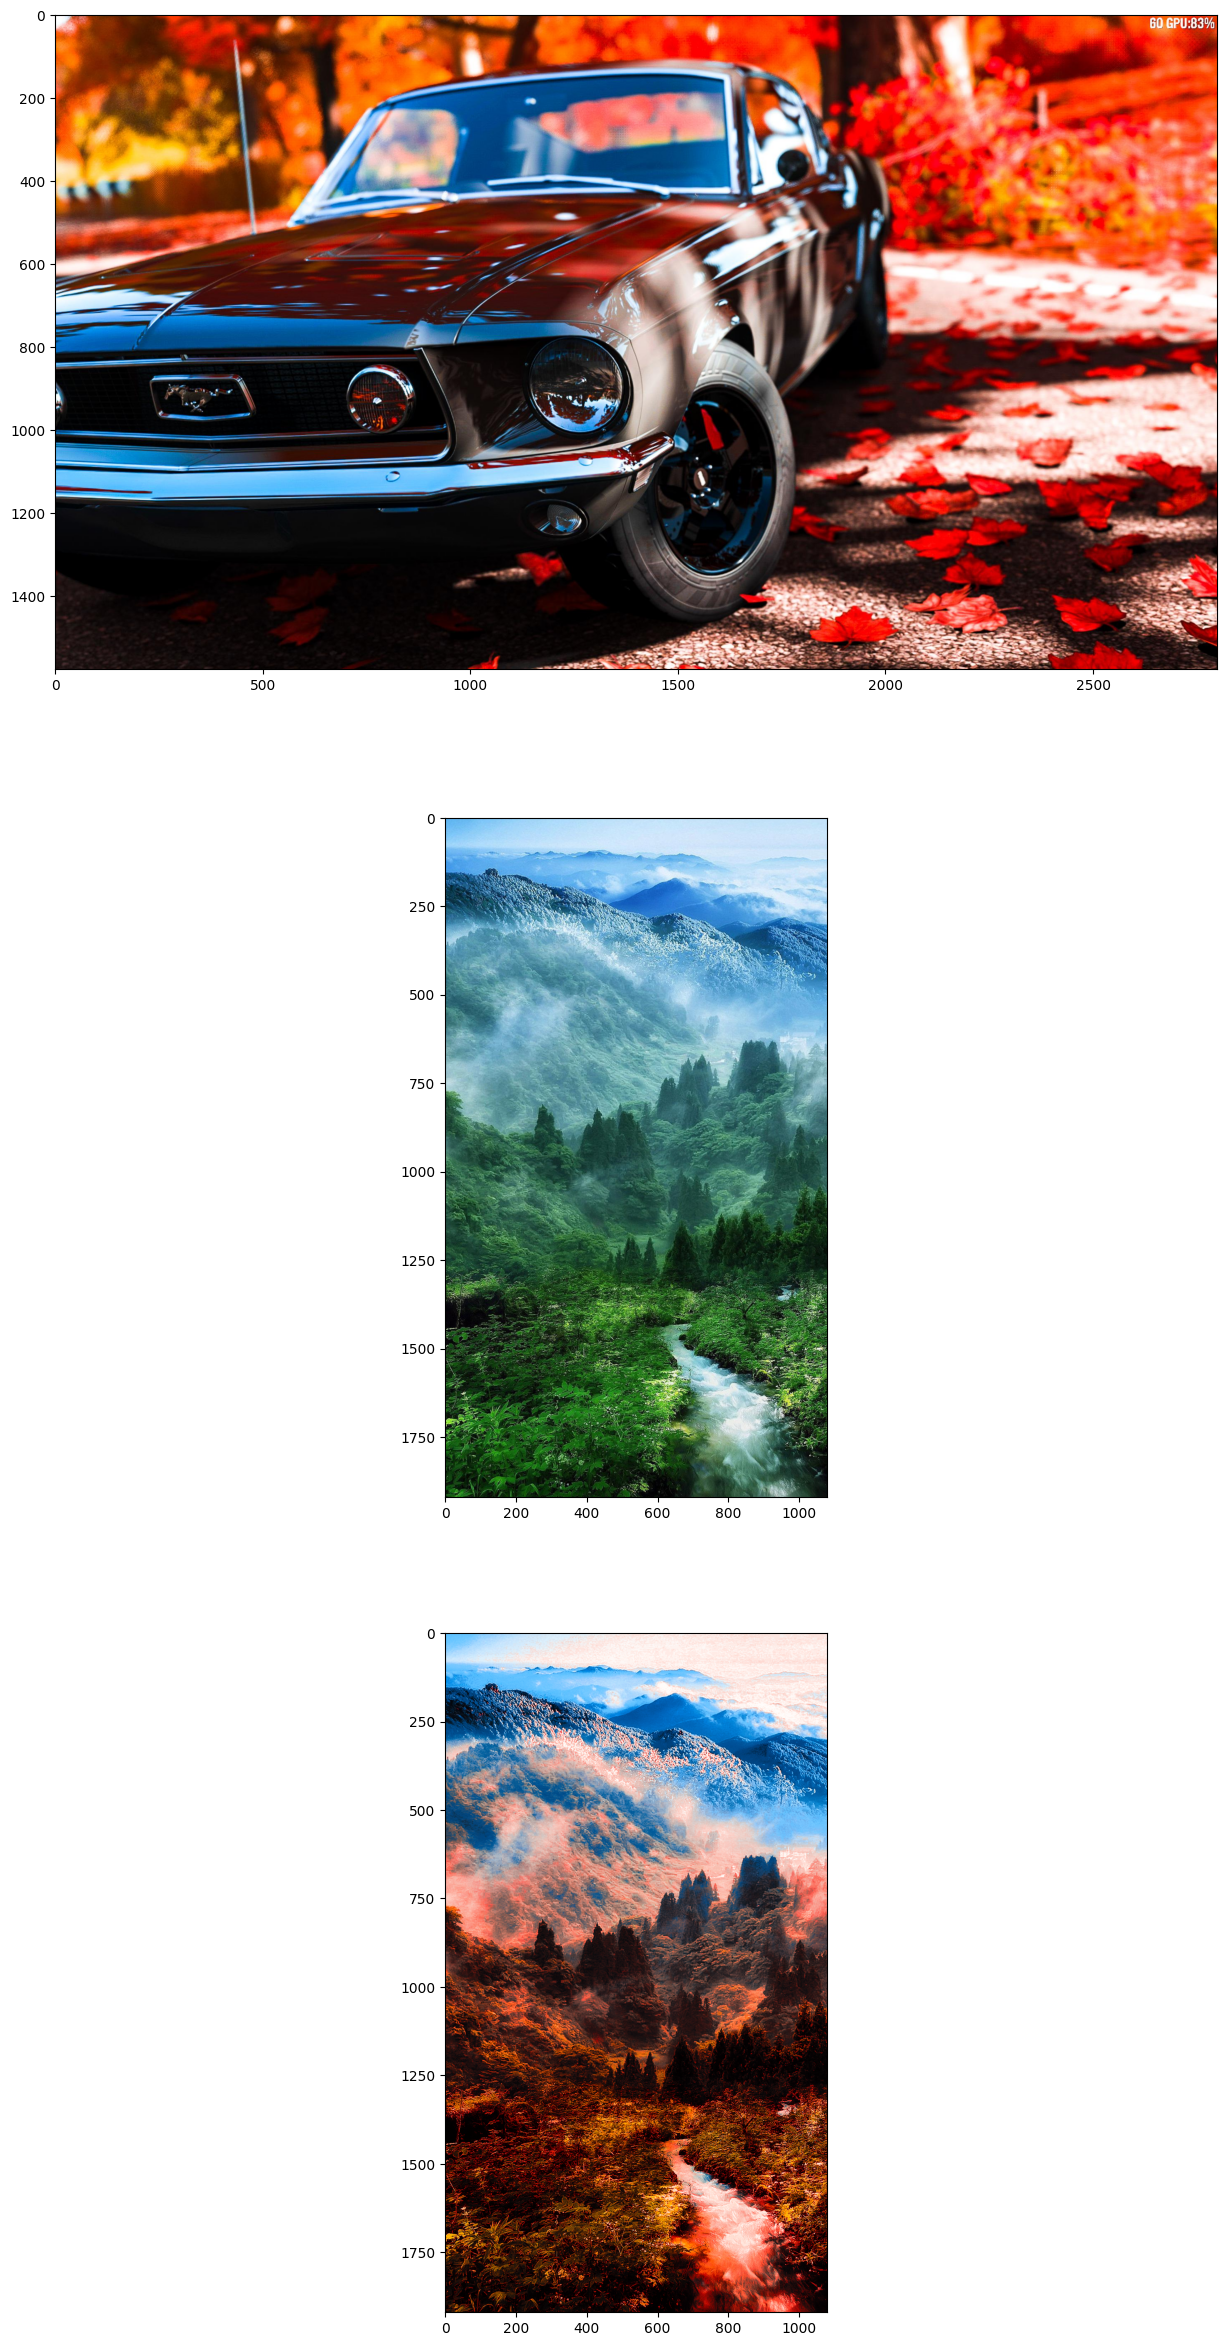

In [9]:
plt.figure(figsize=(15,30))
plt.subplot(3, 1, 1)
plt.imshow(im1)
plt.subplot(3, 1, 2)
plt.imshow(im2)
plt.subplot(3, 1, 3)
plt.imshow(im3)